<a href="https://colab.research.google.com/github/DSF-Kotaro/blog/blob/main/%E5%9B%B3%E8%A7%A3%E9%80%9F%E7%BF%92DeepLearning_009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import output

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
module_metadata_dict = {'dataset': ['CelebA HQ (128x128)', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'LSUN Bedroom', 'CelebA HQ (128x128)', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'LSUN Bedroom', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10'], 'penalty': ['-', '-', '-', '-', '-', '-', '-', '-', 'DRAGAN (lambda=1.000)', 'WGAN (lambda=0.145)', '-', '-', '-', '-', 'WGAN (lambda=1.000)'], 'architecture': ['ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR'], 'beta1': ['0.375', '0.500', '0.585', '0.195', '0.500', '0.500', '0.500', '0.102', '0.500', '0.711', '0.500', '0.500', '0.500', '0.500', '0.500'], 'beta2': ['0.998', '0.999', '0.990', '0.882', '0.999', '0.999', '0.999', '0.998', '0.900', '0.979', '0.999', '0.999', '0.999', '0.999', '0.999'], 'module_url': ['https://tfhub.dev/google/compare_gan/model_1_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_2_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_3_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_4_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_5_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_6_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_7_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_8_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_9_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_10_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_11_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_12_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_13_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_14_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_15_cifar10_resnet_cifar/1'], 'disc_iters': [1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 5, 5, 5, 5], 'model': ['Non-saturating GAN', 'Non-saturating GAN', 'Least-squares GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Least-squares GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN'], 'inception_score': ['2.38', '2.59', '4.23', '4.10', '2.38', '2.54', '3.64', '3.58', '2.34', '3.92', '7.57', '7.47', '7.74', '7.74', '7.70'], 'disc_norm': ['none', 'none', 'none', 'none', 'layer_norm', 'layer_norm', 'spectral_norm', 'spectral_norm', 'layer_norm', 'layer_norm', 'none', 'none', 'spectral_norm', 'spectral_norm', 'spectral_norm'], 'fid': ['34.29', '35.85', '102.74', '112.92', '30.02', '32.05', '41.60', '42.51', '29.13', '40.36', '28.12', '30.08', '22.91', '23.22', '22.73'], 'ms_ssim_score': ['0.32', '0.29', 'N/A', 'N/A', '0.29', '0.28', 'N/A', 'N/A', '0.30', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'], 'learning_rate': ['3.381e-05', '1.000e-04', '3.220e-05', '1.927e-05', '1.000e-04', '1.000e-04', '2.000e-04', '2.851e-04', '1.000e-04', '1.281e-04', '2.000e-04', '1.000e-04', '2.000e-04', '2.000e-04', '2.000e-04']}
MODULE_METADATA = pd.DataFrame.from_dict(module_metadata_dict)

MIN_FID_MODULE = MODULE_METADATA.loc[
    MODULE_METADATA['fid'].astype(float).idxmin()]

SELECTED_MODULE = MIN_FID_MODULE['module_url']
SELECTED_MODULE_DATASET = MIN_FID_MODULE['dataset']

def display_images(images, captions=None):
  batch_size, dim1, dim2, channels = images.shape
  num_horizontally = 8
  
  figsize = (20, 20) if dim1 > 32 else (10, 10)
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=figsize)
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()
  

class ShowModuleTable(object):
  def __init__(self, callback):
    self._callback = callback

  def _repr_html_(self):
    template = """
    <style>
       table {
         font-size: 15px;
         font-family: Inconsolata, monospace;
         border-collapse: collapse;
         border: 1px solid #444444;
       }
       th {
         font-size: 18px;
         background-color: #DDDDDD;
         border: 1px solid #AAAAAA;
         white-space: nowrap;
       }
       tr {
         cursor: pointer;
         white-space: nowrap;
       }
       td {
         padding: 6px 6px 6px 6px;
         border: 1px solid #AAAAAA;
       }
      .selected-row {
        font-weight: bold;
        background-color: #B0BED9;
      }
    </style>
    <table>"""
    
    table_headers = [
      ('dataset', 'Dataset'),
      ('architecture', 'Architecture'),
      ('fid', 'FID'),
      ('inception_score', 'IS'),
      ('ms_ssim_score', 'MS-SSIM'),
      ('model', 'Model'),
      ('learning_rate', 'Learning rate'),
      ('beta1', '&beta;<sub>1</sub>'),
      ('beta2', '&beta;<sub>2</sub>'),
      ('disc_iters', 'n<sub>disc</sub>'),
      ('disc_norm', 'Disc norm'),
      ('penalty', 'Penalty'),
      ('module_url', 'Module name'),
    ]
    header_template = "<tr>"
    for _, header_name in table_headers:
      header_template += "<th>" + header_name + "</th>"
    header_template += "</tr>"
    template += header_template
    
    for i, (_, row) in enumerate(MODULE_METADATA.iterrows()):
      uuid = "row-%s" % i
      
      output.register_callback(uuid, self._callback)
      
      selected_class = ""
      if row['module_url'] == MIN_FID_MODULE['module_url']:
        selected_class = "class=\"selected-row\""

      row_template = "<tr id=\"" + uuid + "\"" + selected_class + ">"
      for key, _ in table_headers:
        row_template += "<td>" + str(row[key]) + "</td>"
      row_template += "</tr>"
      template += row_template
      
    template += """
      </table>
      <script>"""
    
    for i, (_, row) in enumerate(MODULE_METADATA.iterrows()):
      uuid = "row-%s" % i
      m = row['module_url']
      d = row['dataset']
      template += """
        document.querySelector(\"#""" + uuid + """\").onclick = function() {
          google.colab.kernel.invokeFunction('""" + uuid + """', ['""" + m +"""', '""" + d + """'], {});
          var selected = document.getElementsByClassName('selected-row');
          for (var i = 0; i < selected.length; i++) {
            selected[i].classList.remove('selected-row');
          }
          this.classList.toggle("selected-row");
          e.preventDefault();
        };
        """
    template += """</script>"""
    return template


def set_selected_module(module_name, dataset):
  global SELECTED_MODULE
  SELECTED_MODULE = module_name
  global SELECTED_MODULE_DATASET
  SELECTED_MODULE_DATASET = dataset

In [3]:
ShowModuleTable(set_selected_module)

Dataset,Architecture,FID,IS,MS-SSIM,Model,Learning rate,β1,β2,ndisc,Disc norm,Penalty,Module name
CelebA HQ (128x128),ResNet19,34.29,2.38,0.32,Non-saturating GAN,3.381e-05,0.375,0.998,1,none,-,https://tfhub.dev/google/compare_gan/model_1_celebahq128_resnet19/1
CelebA HQ (128x128),ResNet19,35.85,2.59,0.29,Non-saturating GAN,1.000e-04,0.500,0.999,1,none,-,https://tfhub.dev/google/compare_gan/model_2_celebahq128_resnet19/1
LSUN Bedroom,ResNet19,102.74,4.23,N/A,Least-squares GAN,3.220e-05,0.585,0.990,1,none,-,https://tfhub.dev/google/compare_gan/model_3_lsun_bedroom_resnet19/1
LSUN Bedroom,ResNet19,112.92,4.10,N/A,Non-saturating GAN,1.927e-05,0.195,0.882,1,none,-,https://tfhub.dev/google/compare_gan/model_4_lsun_bedroom_resnet19/1
CelebA HQ (128x128),ResNet19,30.02,2.38,0.29,Non-saturating GAN,1.000e-04,0.500,0.999,1,layer_norm,-,https://tfhub.dev/google/compare_gan/model_5_celebahq128_resnet19/1
CelebA HQ (128x128),ResNet19,32.05,2.54,0.28,Non-saturating GAN,1.000e-04,0.500,0.999,1,layer_norm,-,https://tfhub.dev/google/compare_gan/model_6_celebahq128_resnet19/1
LSUN Bedroom,ResNet19,41.60,3.64,N/A,Least-squares GAN,2.000e-04,0.500,0.999,1,spectral_norm,-,https://tfhub.dev/google/compare_gan/model_7_lsun_bedroom_resnet19/1
LSUN Bedroom,ResNet19,42.51,3.58,N/A,Non-saturating GAN,2.851e-04,0.102,0.998,1,spectral_norm,-,https://tfhub.dev/google/compare_gan/model_8_lsun_bedroom_resnet19/1
CelebA HQ (128x128),ResNet19,29.13,2.34,0.30,Non-saturating GAN,1.000e-04,0.500,0.900,5,layer_norm,DRAGAN (lambda=1.000),https://tfhub.dev/google/compare_gan/model_9_celebahq128_resnet19/1
LSUN Bedroom,ResNet19,40.36,3.92,N/A,Non-saturating GAN,1.281e-04,0.711,0.979,1,layer_norm,WGAN (lambda=0.145),https://tfhub.dev/google/compare_gan/model_10_lsun_bedroom_resnet19/1


Using module: "https://tfhub.dev/google/compare_gan/model_15_cifar10_resnet_cifar/1"
Generating images like dataset: "CIFAR10"


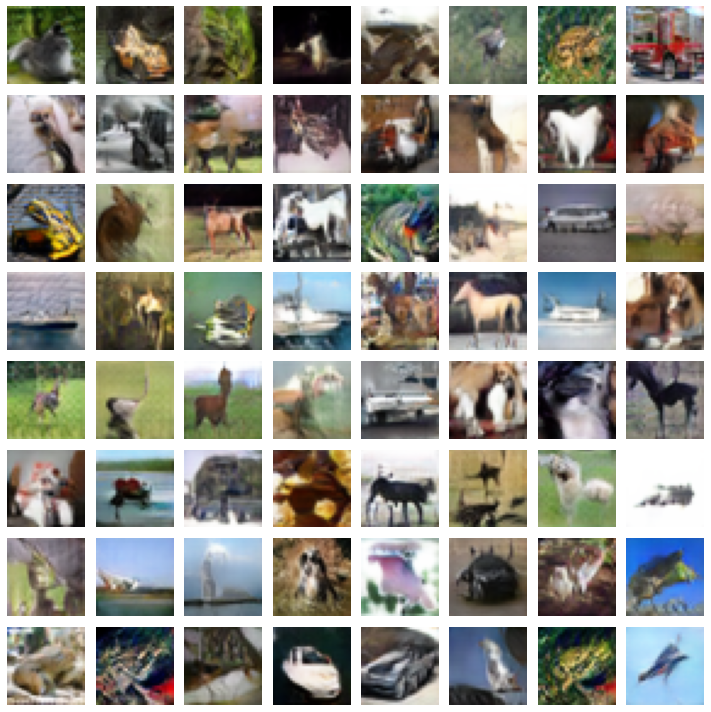

In [4]:
assert SELECTED_MODULE is not None and SELECTED_MODULE_DATASET is not None, \
  'You must run the above cell and select a module from the table to generate images.'

print('Using module: "%s"' % SELECTED_MODULE)
print('Generating images like dataset: "%s"' % SELECTED_MODULE_DATASET)

# The generator expects a batch of 64 vectors of size 128
batch_size = 64
z_dim = 128

with tf.Graph().as_default():
  # Load the selected module
  gan = hub.Module(SELECTED_MODULE)
  z_input = tf.compat.v1.placeholder(dtype=tf.float32, shape=(batch_size, z_dim))
  image_output = gan(z_input, signature="generator") 
  
  with tf.compat.v1.train.MonitoredSession() as session:
    # Generate 64 random vectors as input to the latent space to generate images
    z_values = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    images = session.run(image_output, feed_dict={z_input: z_values})

    # View the resulting images
    display_images(images)